In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

##Import and Preprocess data

Single images of pollen grains from 42 different classes

Images are augmented from keras ImageDataGenerator

Images are also resized to 224,224,3 for VGG16 input



In [3]:
%cd /content/
%mkdir img
!cp /content/gdrive/My\ Drive/USPollenKeras/USPollen.rar /content/img/

/content


In [4]:
%cd img/
!unrar x /content/img/USPollen.rar /content/img/
%cd USPollen/

/content/img

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/img/USPollen.rar

Creating    /content/img/USPollen                                     OK
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #2.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #3.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #4.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #5.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #6.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM.jpg       0%  OK 
Extracting  /content/img/USPoll

In [5]:
import glob
import numpy as np
import os
width = 224
height = 224
dim = (width, height)

data = []
labels = []
glober = []

with open("/content/gdrive/My Drive/USPollen/classes.txt","r") as f:
  for line in f.readlines():
    key = line.strip()
    glober = glob.glob("*"+key+"*.jpg")
    myClass = np.array(glober)
    for i in myClass:
      img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
      resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      data.append(resized)
      labels.append(key)
      



In [8]:
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
# encode the labels (which are currently strings) as integers and then
# one-hot encode them
le = LabelEncoder()

labels = le.fit_transform(labels)

#labels = to_categorical(labels, 46)


#Split into training data and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.1, random_state=42)



In [ ]:
trainY.shape


(1826,)

##Kmeans Split

- the training data will be split 10 ways 

- the origional testX and testY will not be used in the split so we can get an idea of how the model will classify images it has not seen before

In [ ]:

aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")


##Transfer Learned Model

Using VGG16 

Freezing layers after 17 and adding custom layers for 42 class output

In [6]:
model = applications.ResNet50V2(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))


for layer in model.layers[:17]:
    layer.trainable = False



#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(4096, activation="relu")(x)

predictions = Dense(42, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input,predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
model_final.summary()

##Load model

In [7]:
!cp /content/gdrive/My\ Drive/USPollenKeras/ResNet/ResNet50V2_10.h5 ./

model_final.load_weights('ResNet50V2_10.h5')


In [ ]:
dir = "/content/gdrive/My Drive/USPollenKeras/"
f = open(dir,"w+")
f.write("img/USPollen/"+"\n")

14

##Train Model

Number of Images in dataset: 2029

Augment

In [ ]:

dir = "/content/gdrive/My Drive/USPollenKeras/ResNet/"

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
count = 0
all_scores = []
for train, test in kfold.split(trainX, trainY):
  count=count+1

  #y vec needs to be 1d vector of all labels initally
  #change to categorical values after the split
  #https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
  cat_trainY = to_categorical(trainY[train], 42)
  cat_testY = to_categorical(trainY[test], 42)
  #generator
  train_generator=aug.flow(trainX[train],cat_trainY, batch_size=64)
  #fit the model
  H=model_final.fit(train_generator,batch_size=64,epochs=32,verbose=1)
  # evaluate the model
  scores = model_final.evaluate(trainX[test], cat_testY, verbose=0)
  print("%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))
  all_scores.append(scores[1] * 100)
  print("Saving weights")  
  model_final.save_weights(dir+"ResNet50V2_"+repr(count)+".h5")
 
print("%.2f%% (+/- %.2f%%)" % (np.mean(all_scores), np.std(all_scores)))
print("Saving final weights")  
model_final.save_weights('ResNet50V2_final.h5')




Epoch 1/32
26/26 [==============================] - 15s 576ms/step - loss: 3.2504 - accuracy: 0.1266
Epoch 2/32
26/26 [==============================] - 15s 571ms/step - loss: 2.7498 - accuracy: 0.2258
Epoch 3/32
26/26 [==============================] - 15s 582ms/step - loss: 2.6964 - accuracy: 0.2441
Epoch 4/32
26/26 [==============================] - 15s 569ms/step - loss: 2.3941 - accuracy: 0.2897
Epoch 5/32
26/26 [==============================] - 15s 573ms/step - loss: 2.2543 - accuracy: 0.3165
Epoch 6/32
26/26 [==============================] - 15s 572ms/step - loss: 2.1245 - accuracy: 0.3792
Epoch 7/32
26/26 [==============================] - 15s 564ms/step - loss: 2.1311 - accuracy: 0.3865
Epoch 8/32
26/26 [==============================] - 15s 570ms/step - loss: 2.2174 - accuracy: 0.3488
Epoch 9/32
26/26 [==============================] - 15s 570ms/step - loss: 1.9854 - accuracy: 0.3834
Epoch 10/32
26/26 [==============================] - 15s 569ms/step - loss: 1.6320 - accura

##Run cell below this

In [ ]:
model_final.save_weights('VGG16weights_final.h5')


In [ ]:
!cp /content/img/USPollen/VGG16weights_final.h5 /content/gdrive/My\ Drive/USPollenKeras/


##Testing Results

In [ ]:
trained_model = model_final.load_weights('VGG16weights_10.h5')

In [ ]:
le = LabelEncoder()

labels = le.fit_transform(labels)

labels = to_categorical(labels, 42)


#Split into training data and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.1, random_state=42)

ValueError: ignored

In [ ]:
score = model_final.evaluate(testX,testY,verbose = 0)
print("%s: %.2f%%" % (model_final.metrics_names[1], score[1]*100))


In [10]:
#Y_test = np.argmax(testY, axis=1)
y_pred = model_final.predict(testX)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(testY,y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.79      0.85      0.81        13
           2       1.00      0.50      0.67         8
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       1.00      0.50      0.67         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         3
          13       0.75      1.00      0.86         3
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          16       1.00      0.67      0.80         3
          17       1.00    

In [11]:
y_pred = model_final.predict(testX)
y_pred = np.argmax(y_pred, axis=1)

le = LabelEncoder()
enc_lables = le.fit_transform(labels)
classification_guess = le.inverse_transform(y_pred)
 
dic = dict([])

dic

{}

Saving 0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #2.jpg to 0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #2 (1).jpg


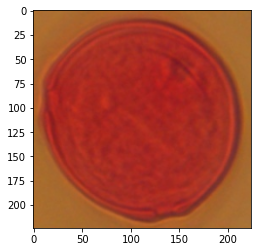

Predicted: array([6.13166048e-05, 8.11226899e-04, 4.82052891e-03, 5.87728709e-06,
       4.02149226e-06, 1.68335532e-06, 1.11877953e-05, 1.07805143e-04,
       2.42500300e-06, 5.19734807e-04, 5.07979203e-05, 9.49665785e-01,
       3.00008035e-03, 1.75883033e-05, 1.61074765e-03, 2.72868274e-05,
       5.21607071e-05, 5.47136087e-03, 1.32926996e-03, 1.59206000e-04,
       3.09376954e-03, 1.30921253e-03, 6.12347358e-05, 3.82500904e-04,
       1.89536950e-04, 8.00937300e-07, 1.11907240e-04, 1.72209067e-04,
       3.79465433e-04, 4.23423626e-04, 9.86871962e-03, 2.12006923e-03,
       1.49508138e-04, 8.20962305e-05, 4.14575078e-03, 7.97304511e-03,
       1.31984325e-05, 3.89328161e-05, 1.32019586e-05, 1.46941782e-03,
       1.74682395e-06, 2.70130608e-04], dtype=float32)


In [10]:
from google.colab import files
uploaded = files.upload()

imgs = []

for fn in uploaded.keys():
  img = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
  resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
  imgs.append(resized)

test = np.array(imgs)

test = np.array(test, dtype="float") / 255.0

y_pred = model_final.predict(test)

y_pred = y_pred*100

for val,i in enumerate(test):
  b,g,r = cv2.split(i)           # get b, g, r
  img = cv2.merge([r,g,b])
  imgs.append(img)
  plt.imshow(img)
  plt.show()
  print("Predicted: "+repr(y_pred[val]))